In [1]:
import h5py
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from numpy.random import randn
from sklearn.utils import shuffle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
import patchify as ptch
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from numpy.linalg import solve

## Accelerated manifold denoising (AMD)

In [2]:
def AMD(Y, n_neighbors, lambd, n_iterations=5):
    
    # Initialization
    X = Y[:,:]
    
    U = X[:, :]
    V = X[:, :]
    
    # Number of samples
    n = X.shape[0]
    
    for k in range(n_iterations):
    
        # Compute k-NN distances
        p_dist = pairwise_distances(X)
        p_dist_sorted = np.sort(p_dist, axis=1)

        # Determine distances to the k-th nearest neighbors
        knn_dist = p_dist_sorted[:, n_neighbors]

        # Compute bandwidths
        H = np.maximum(np.outer(knn_dist, np.ones(n)), np.outer(np.ones(n), knn_dist)) 
        H_inv = np.diag(1 / knn_dist)
        
        # Compute weights
        H2 = H**2
        W = np.exp(-0.5 * p_dist**2 / H2) * (p_dist < H)
        
        # Compute D
        d = np.sum(W, axis=1)
        D = np.diag(d)
        D_inv = np.diag(1 / d)
        
        # Compute graph Laplacian
        L = D - W
        
        b = 2 * np.max(d)
        alpha = (k+2) / 2 / b
        tau = 2 / (k+2)
        
        X = tau * V + (1 - tau) * U
        
        U = solve(b * np.eye(n) + lambd * (H_inv**2 @ L), b * X - D @ X + W @ Y)
        V_new = solve(np.eye(n) + lambd * (H_inv**2) @ (D_inv @ L), V - alpha * X + alpha * (D_inv @ (W @ Y)))
        V = V_new[:,:]
        
    # Return the denoised point cloud
    return U

## Application to superresolution

### Preprocessing

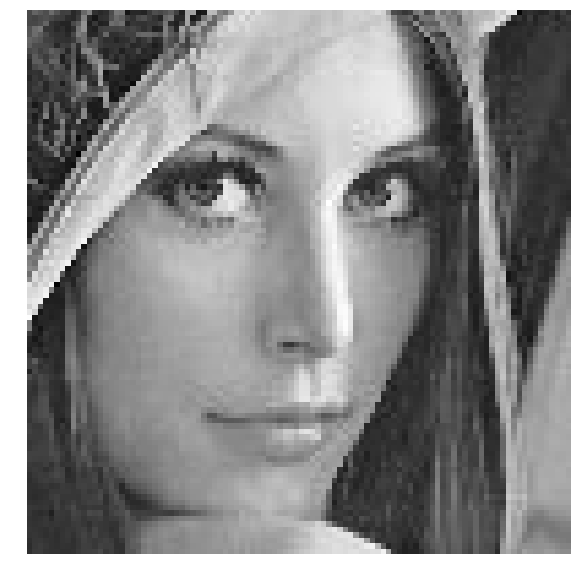

In [4]:
# Read the image
lena = plt.imread('lena_gray.jpg')
lena = lena * 1./255

# Lena
lena = lena[100:200, 100:200]

plt.figure(figsize=(10,10))
plt.imshow(lena, cmap='gray')
plt.axis('off')
plt.show()
plt.close()

### Impainting

Number of remained pixels:  1156 out of 10000


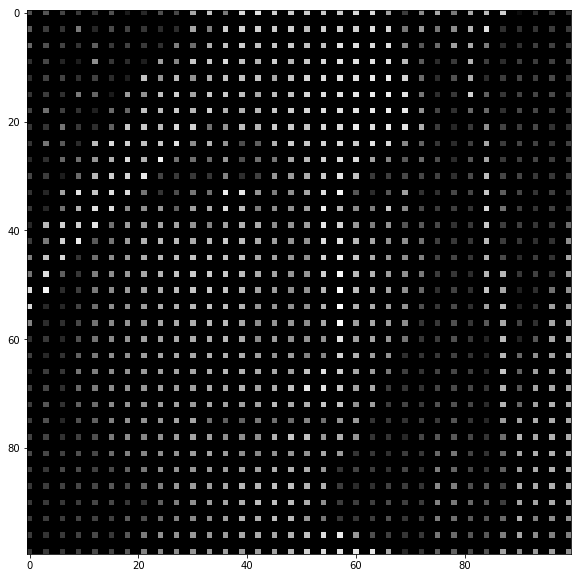

In [6]:
# Distance between remaining pixels
pix_dist = 3
# coordinates of remaining pixels
coord = []
z = []

mask = np.ones((lena.shape[0], lena.shape[1]))

for i in range(lena.shape[0]):
    for j in range(lena.shape[1]):
        
        if ((i % pix_dist) == 0) and (j % pix_dist == 0):
            
            coord += [[i, j]]
            z += [lena[i, j]]
            
        else:
            mask[i, j] = 0
            
print("Number of remained pixels: ", np.sum(mask == 1), "out of", lena.shape[0] * lena.shape[1])
lena_imp = lena * mask

lena_blurred = lena_imp

plt.figure(figsize=(10,10))
plt.imshow(lena_blurred, cmap='gray')
plt.show()
plt.close()

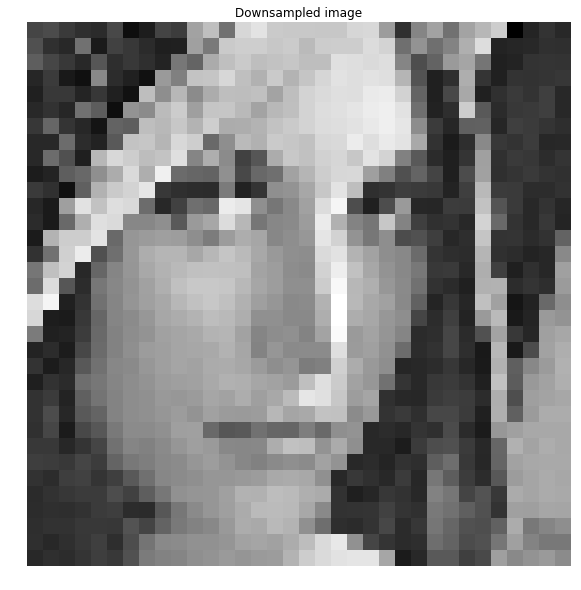

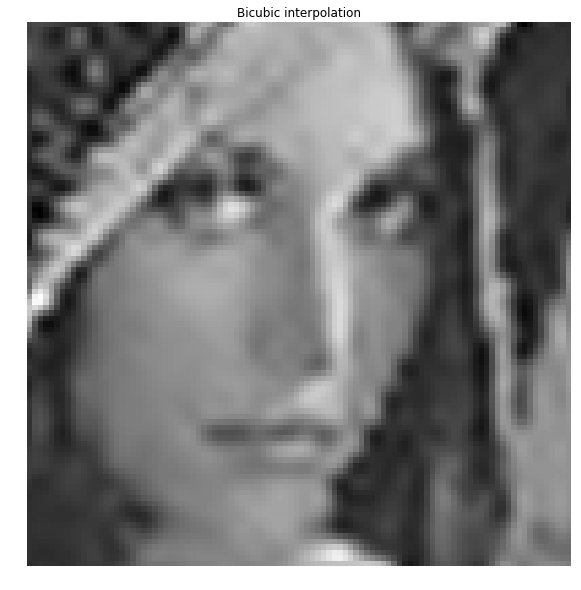

In [7]:
# Initial guess via bicubic interpolation
xx = np.arange(0, lena.shape[0], pix_dist)
yy = np.arange(0, lena.shape[1], pix_dist)

z = np.ones((xx.shape[0], yy.shape[0]))
for i in range(xx.shape[0]):
    for j in range(yy.shape[0]):
        
        z[i, j] = lena[xx[i], yy[j]]

plt.figure(figsize=(10,10))
plt.imshow(z, cmap='gray')
plt.axis('off')
plt.title('Downsampled image')
plt.show()
plt.close()

f = RectBivariateSpline(xx, yy, z)

lena_interp = np.zeros((lena.shape[0], lena.shape[1]))
for i in range(lena.shape[0]):
    for j in range(lena.shape[1]):
        
        lena_interp[i, j] = f(i, j)
        
plt.figure(figsize=(10,10))
plt.imshow(lena_interp, cmap='gray')
plt.axis('off')
plt.title('Bicubic interpolation')
plt.show()
plt.close()

### Denoising via AMD algorithm

#### Step 1: patchification

/Users/nikita/anaconda/lib/python3.6/site-packages/skimage/util/shape.py:255: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr_in[slices].strides


(81, 81, 20, 20)
(6561, 400)


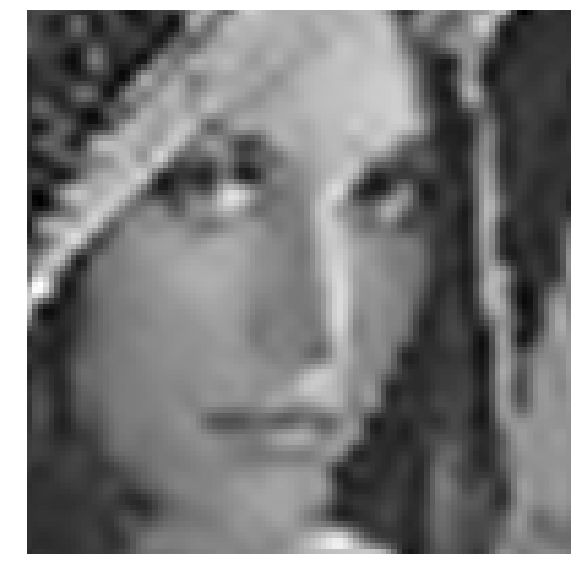

In [5]:
# Create patches

patches = ptch.patchify(lena_interp, (20, 20), step=1)

print(patches.shape)
n_h, n_w, p_h, p_w = patches.shape

Y = patches.reshape(n_h*n_w, p_h*p_w)
print(Y.shape)

restored = ptch.unpatchify(patches, lena.shape)

plt.figure(figsize=(10,10))
plt.imshow(restored, cmap='gray')
plt.axis('off')
plt.show()
plt.close()

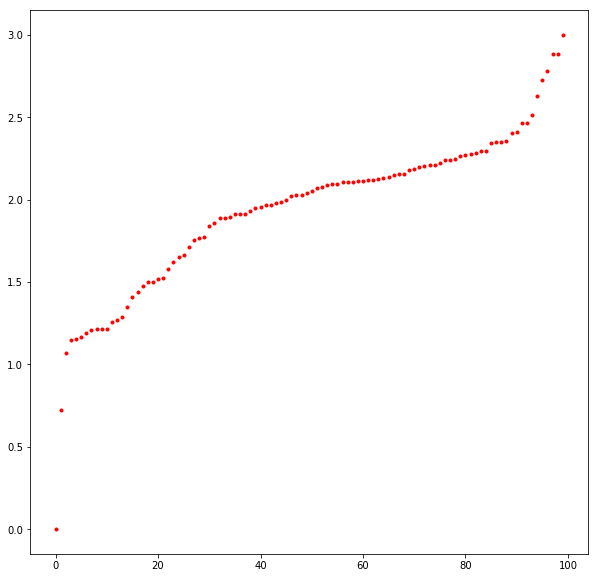

In [6]:
X0 = lena_interp[-1]
dist = np.linalg.norm(lena_interp - X0, axis=1)
dist_sorted = np.sort(dist)

plt.figure(figsize=(10,10))
plt.plot(np.arange(lena_interp.shape[0]), dist_sorted, 'r.')
#plt.xlim(0, 500)
#plt.ylim(0, 2)
plt.show()
plt.close()

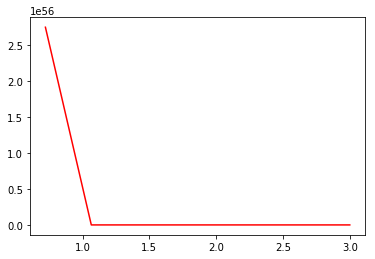

In [7]:
X0 = lena_interp[-1]
dist = np.linalg.norm(lena_interp - X0, axis=1)
dist_sorted = np.sort(dist)

plt.figure()
plt.plot(dist_sorted[1:], np.arange(1, dist_sorted.shape[0]) / dist_sorted[1:]**Y.shape[1], 'r-')
plt.show()
plt.close()

#### Step 2: denoising

In [8]:
# Ambient dimension
D = Y.shape[1]

# Sample size
n_samples = Y.shape[0]

lambd = 3
n_neighbors = 9
n_iterations = 2

In [9]:
# Denoising
X_denoised = AMD(Y, n_neighbors, lambd, n_iterations)

# Show the average change
print(np.linalg.norm(X_denoised - Y, ord='fro')**2 / n_samples)        

0.1736479792107209


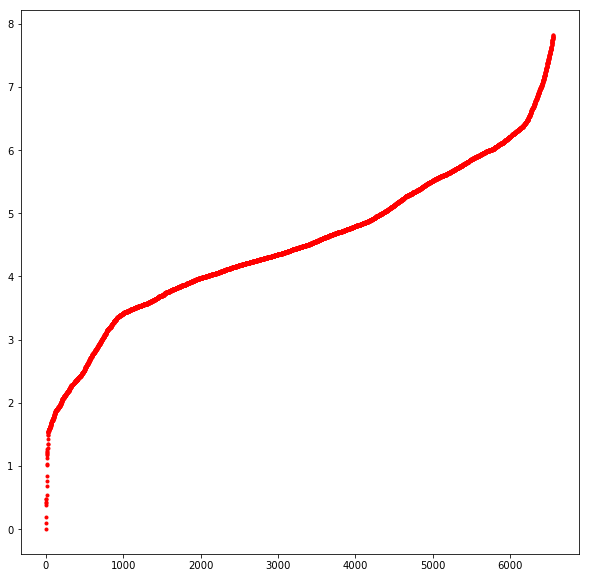

In [10]:
X0 = X_denoised[-1]
dist = np.linalg.norm(X_denoised - X0, axis=1)
dist_sorted = np.sort(dist)

plt.figure(figsize=(10,10))
plt.plot(np.arange(X_denoised.shape[0]), dist_sorted, 'r.')
#plt.xlim(0, 500)
#plt.ylim(0, 2)
plt.show()
plt.close()

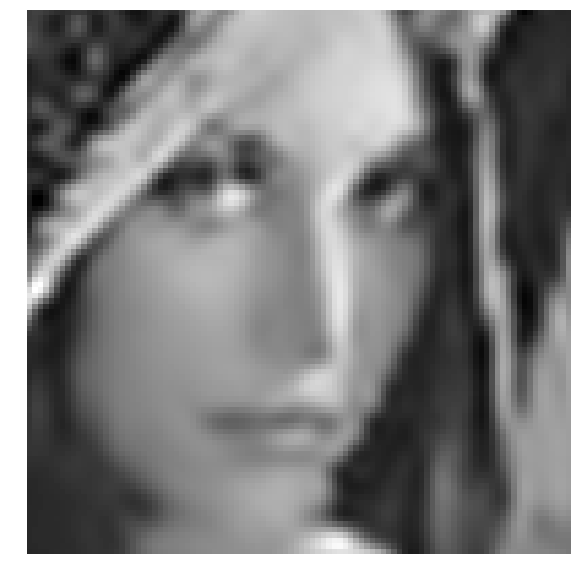

In [11]:
patches_denoised = X_denoised.reshape(n_h, n_w, p_h, p_w)

denoised = ptch.unpatchify(patches_denoised, lena.shape)

plt.figure(figsize=(10,10))
plt.imshow(denoised, cmap='gray')
plt.axis('off')
plt.show()
plt.close()

### Performance evaluation

In [12]:
print('Frobenius norm between true and blurred images:', np.linalg.norm(lena-lena_blurred, 'fro'))
print('Frobenius norm between true and denoised images:', np.linalg.norm(lena-denoised, 'fro'))

46.704934713226
7.09198845432956


In [13]:
print('PSNR for bicubic interpolaiton:',\
      -20 * np.log(np.linalg.norm(lena-lena_interp, 'fro') / np.sqrt(lena.shape[0] * lena.shape[1])) / np.log(10))
print('PSNR for AMD:',\
      -20 * np.log(np.linalg.norm(lena-denoised, 'fro') / np.sqrt(lena.shape[0] * lena.shape[1])) / np.log(10))

22.52755860989346
22.98463960193295
